In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [0]:
x_train = np.memmap('drive/My Drive/Xtrain.dat', shape=(600000, 2351), dtype=np.float32)
y_train = np.memmap('drive/My Drive/Ytrain.dat', dtype=np.float32)
# 0 for benign (nb of elm => 300000)
# 1 for malicious (nb of elm => 300000)

In [4]:
print(x_train)

[[  3.7433937   1.3417011   1.5087795 ...   0.          0.
    0.       ]
 [ 18.43898     4.467576    4.2452645 ...   0.          0.
    0.       ]
 [ 47.065903    9.949453    2.189625  ...   0.          0.
    0.       ]
 ...
 [134.32236     2.8423796   2.7915328 ...   0.          0.
    0.       ]
 [129.39911     3.1475294   1.9884748 ...   0.          0.
    0.       ]
 [174.9149      1.3446283   1.5648073 ...   0.          0.
    0.       ]]


In [5]:
print(y_train)

[0. 0. 0. ... 1. 1. 1.]


In [6]:
# dimension reduction
print(x_train.shape)
x_train = np.delete(x_train, np.s_[-47:], axis=1)
print(x_train.shape)

(600000, 2351)
(600000, 2304)


In [0]:
# normalize the data (pixels range [0, 255])
min_max_scaler = preprocessing.MinMaxScaler((0, 255), copy=False)
x_train = min_max_scaler.fit_transform(x_train)

In [8]:
print(x_train)

[[  3.7148898   1.3417011   1.5087795 ...  27.967741  151.48515
  194.90779  ]
 [ 18.410475    4.467576    4.2452645 ...  27.967741  151.48515
  194.90779  ]
 [ 47.037395    9.949453    2.189625  ...  27.967741  151.48515
  194.90779  ]
 ...
 [134.29384     2.8423796   2.7915328 ...  27.967741  151.48515
  194.90779  ]
 [129.37059     3.1475294   1.9884748 ...  27.967741  151.48515
  194.90779  ]
 [174.88638     1.3446283   1.5648073 ...  27.967741  151.48515
  194.90779  ]]


In [0]:
# reshape the data to consider vectors as images
x_train = np.reshape(x_train, (600000, 48, 48))

In [0]:
# define the classes
classes = ['benign', 'malicious']

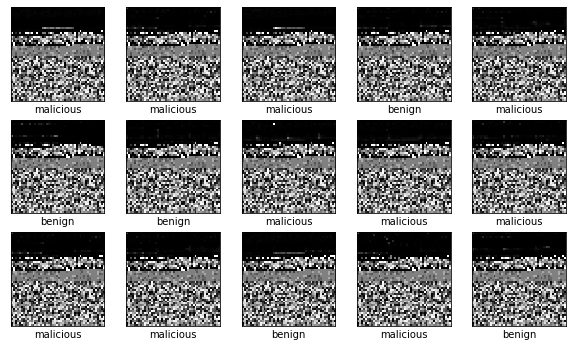

In [11]:
# graphical representation of the malwares
plt.figure(figsize=(10,10))
cpt = 1
for i in range(50000, 50015):
  plt.subplot(5, 5, cpt)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], 'gray')
  plt.xlabel(classes[int(y_train[i])])
  cpt += 1
plt.show()

In [0]:
# reshape data for the input of the CNN-LSTM
x_train = np.reshape(x_train, (600000, 48, 48, 1))
# normalization of the pixels (easier training) [0, 1]
x_train = x_train / 255.0

In [13]:
# split the data into two parts (training set and test set)
x_train, x_test = x_train[:550000], x_train[550000:]
y_train, y_test = y_train[:550000], y_train[550000:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(550000, 48, 48, 1)
(550000,)
(50000, 48, 48, 1)
(50000,)


In [0]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, LSTM, TimeDistributed, Reshape
from keras import optimizers

from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

In [0]:
# definition of the swish activation funtion for tests
def swish(x):
  return x * sigmoid(x)

get_custom_objects().update({'swish': Activation(swish)})

In [0]:
# create the model of CNN-LSTM

# CNN part
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='swish', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='swish'))
model.add(MaxPooling2D(2, 2))

# transition
model.add(Flatten())
model.add(Dense(400, activation='swish'))
model.add(Reshape((1, 400)))

# LSTM part
model.add(LSTM(16, activation='swish', input_shape=(1, 400)))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               1280400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 400)           

In [0]:
# compile model
adm = optimizers.adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=adm, metrics=['accuracy'])

In [19]:
# fit our model
history = model.fit(x_train, y_train, validation_split=0.15, epochs=4, shuffle=True)

467500/467500 [==============================] - 170s 364us/step - loss: 0.1622 - acc: 0.9340 - val_loss: 0.0981 - val_acc: 0.9619
Epoch 2/4
467500/467500 [==============================] - 150s 321us/step - loss: 0.1003 - acc: 0.9620 - val_loss: 0.0713 - val_acc: 0.9756
Epoch 3/4
467500/467500 [==============================] - 152s 324us/step - loss: 0.0811 - acc: 0.9699 - val_loss: 0.0572 - val_acc: 0.9781
Epoch 4/4
467500/467500 [==============================] - 149s 318us/step - loss: 0.0692 - acc: 0.9747 - val_loss: 0.0517 - val_acc: 0.9811


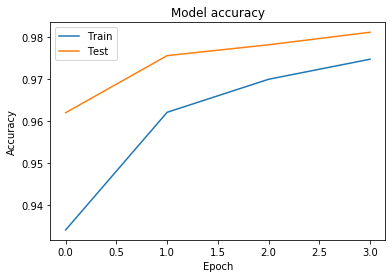

In [20]:
# evaluate our model

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print("loss: " + str(loss))
print("acc: " + str(acc))

loss: 0.04545454722076654
acc: 0.98194
